In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [22]:
def readInFile(filename, airports=False):
    results = {}
    with open(filename) as f:
        for line in f:
            line = line.replace("(", "")
            line = line.replace(")", "")
            lineStats = line.strip().split(",")
            if airports:
                results[lineStats[0]] = generatePercentileString(lineStats[2:])
            else:
                results[lineStats[0]] = generatePercentileString(lineStats[1:])
    if airports:
        return results
    
    sortedResults = {}
    for k, v in sorted( results.items() ):
        sortedResults[k] = v
        
    monthResults = {}
    for k, v in sortedResults.items():
        month = k[5:7]
        if month not in monthResults:
            monthResults[month] = {}
        monthResults[month][k] = v

    return monthResults

In [39]:
def generatePercentileString(lineStats):
    minV = float( lineStats[0] )
    maxV = float( lineStats[1] )
    median = float( lineStats[2] )
    Q1 = float( lineStats[3] )
    Q3 = float( lineStats[4] )
    avg = float( lineStats[5] )
    count = int( lineStats[6] )
    
    threshold = float( lineStats[7] )
    if threshold < maxV:
        maxV = threshold
        
    outliers = lineStats[8].split(" ")
    if outliers[0] is '':
        outliers = None
    else:
        outliers = list(map(float, outliers))
        
    return [ [minV, Q1, median, Q3, maxV, outliers], avg, count ]

def getPercentiles(stats):
    percentiles = {}
    for month, days in stats.items():
        percentiles[month] = []
        for date, stats in days.items():
            percentiles[month].append(stats[0])
    return percentiles

def getPerecentilesAirport(stats):
    percentiles = []
    labels = []
    for airport, values in stats.items():
        labels.append(airport)
        percentiles.append(values[0])
    return percentiles, labels

In [4]:
def customized_box_plot(percentiles, axes, redraw = True, *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    https://stackoverflow.com/questions/27214537/
    is-it-possible-to-draw-a-matplotlib-boxplot-given-the-percentile-values-instead
    """
    n_box = len(percentiles)
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, *args, **kwargs) 
    # Creates len(percentiles) no of box plots

    min_y, max_y = float('inf'), -float('inf')

    for box_no, (q1_start, 
                 q2_start,
                 q3_start,
                 q4_start,
                 q4_end,
                 fliers_xy) in enumerate(percentiles):

        # Lower cap
        box_plot['caps'][2*box_no].set_ydata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_ydata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_ydata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_ydata([q4_start, q4_end])

        # Box
        box_plot['boxes'][box_no].set_ydata([q2_start, 
                                             q2_start, 
                                             q4_start,
                                             q4_start,
                                             q2_start])

        # Median
        box_plot['medians'][box_no].set_ydata([q3_start, q3_start])
        
        #Convert fliers to proper format
        if fliers_xy is not None:
            fliers_x = np.array( [box_no +1 for _ in fliers_xy] )
            fliers_xy = [fliers_x, np.array( fliers_xy )]
        
        # Outliers
        if fliers_xy is not None and len(fliers_xy[0]) != 0:
            # If outliers exist
            box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
                                           ydata = fliers_xy[1])

            min_y = min(q1_start, min_y, fliers_xy[1].min())
            max_y = max(q4_end, max_y, fliers_xy[1].max())

        else:
            min_y = min(q1_start, min_y)
            max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
        axes.set_ylim([min_y*1.1, max_y*1.1])

    # If redraw is set to true, the canvas is updated.
    if redraw:
        axes.figure.canvas.draw()

    return box_plot

In [62]:
def plotMonth(filename, month):
    stats = readInFile(filename)
    percentiles = getPercentiles(stats)
    fig, ax = plt.subplots()
    b = customized_box_plot(percentiles[month], ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
    ax.set_title(month + " 2018 Delay Times From Denver to Chicago")
    ax.tick_params(axis='x', pad=0.5, labelsize='small', labelrotation=30)
    ax.set_ylabel("Minutes Delayed")
    ax.set_xlabel("Date")
    ax.grid()

    plt.savefig("AtoBYear" + month + ".png")

def plotYear(filename, setMax=False):
    stats = readInFile(filename)
    percentiles = getPercentiles(stats)
    
    fig, axes = plt.subplots(4, 3, figsize=(25,25))
    fig.suptitle("2018 Delay Times From Denver to Chicago", fontsize=24)
    fig.subplots_adjust(top=0.95)
    months = list( percentiles.keys() )
    i = 0
    
    for axRow in axes:
        for ax in axRow:
            b = customized_box_plot(percentiles[months[i]], ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
            ax.set_title("Month: {}".format(months[i]))
            if setMax:
                ax.set_ylim([0, 1100])
            ax.tick_params(axis='x', pad=0.5, labelsize='small', labelrotation=30)
            ax.grid()
            i += 1

    plt.savefig("AtoBYear.png")

def plotAirports(filename):
    stats = readInFile(filename, True)
    percentiles, labels = getPerecentilesAirport(stats)
    fig, ax = plt.subplots(figsize=(10,10))
    b = customized_box_plot(percentiles, ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
    ax.set_title(" [ADD DATE] Delay Times From Denver to Top 25 Cities", fontsize=20)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', pad=0.5, labelsize='large', labelrotation=90)

    ax.set_ylabel("Minutes Delayed", fontsize=15)
    ax.set_xlabel("City", fontsize=15)
    ax.grid()
    plt.tight_layout()
    plt.savefig("top25Cites.png")

In [71]:
def writeCSVforGeoMaps(filename):
    stats = readInFile(filename, True)
    with open("geomap.csv", 'w') as f:
        f.write("City,Average Delay\n")
        for city, v in stats.items():
            f.write(city + "," + str(v[1]) + '\n')

In [72]:
writeCSVforGeoMaps("cool.txt")

In [65]:
stats

{'Kansas City': [[2.0, 7.0, 15.0, 28.0, 31.0, None], 17.428571428571427, 7],
 'Dallas/Fort Worth': [[1.0, 10.0, 31.0, 62.0, 98.0, None],
  36.42857142857143,
  7],
 'Las Vegas': [[2.0, 12.0, 23.0, 51.0, 109.5, [116.0]], 34.25, 12],
 'Newark': [[26.0, 57.0, 95.0, 148.0, 173.0, None], 97.11111111111111, 9],
 'Los Angeles': [[1.0, 8.0, 18.0, 94.0, 223.0, [233.0, 234.0]], 64.5, 10],
 'Oklahoma City': [[2.0, 5.0, 44.0, 54.0, 54.0, None], 26.25, 4],
 'Washington': [[1.0, 3.0, 22.0, 29.0, 68.0, [142.0]], 33.0, 9],
 'Houston': [[1.0, 8.0, 21.0, 51.0, 59.0, None], 25.0, 8],
 'San Diego': [[6.0, 17.0, 29.0, 33.0, 33.0, None], 21.25, 4],
 'Atlanta': [[1.0, 2.0, 5.0, 20.0, 47.0, [57.0, 157.0]], 26.3, 10],
 'Portland': [[3.0, 7.0, 18.0, 51.0, 64.0, None], 25.375, 8],
 'Boston': [[1.0, 40.0, 51.0, 71.0, 117.5, [133.0]], 50.5, 8],
 'New York': [[4.0, 10.0, 17.0, 57.0, 127.5, [586.0]], 93.11111111111111, 9],
 'Salt Lake City': [[4.0, 14.0, 52.0, 62.0, 94.0, None], 42.125, 8],
 'Charlotte': [[4.0, 5.0,

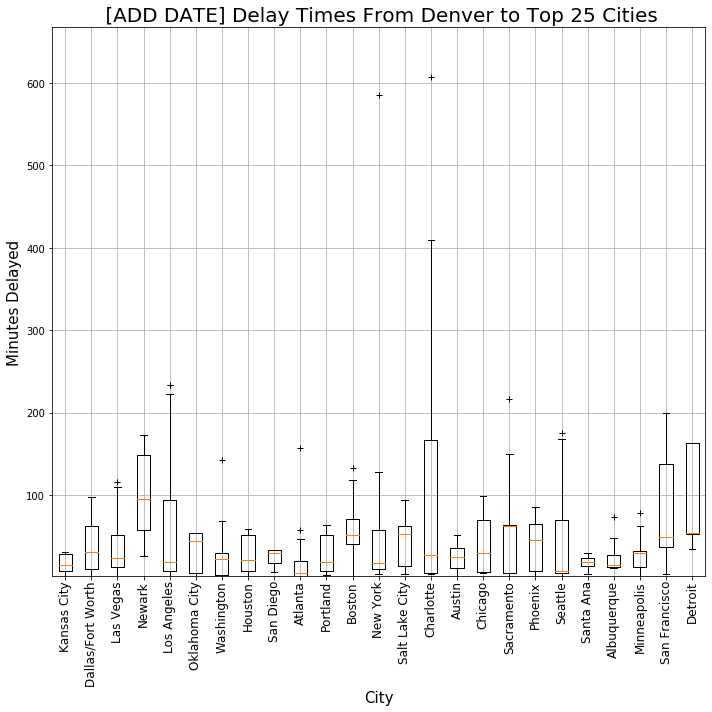

In [63]:
plotAirports("withoutAirport.txt")

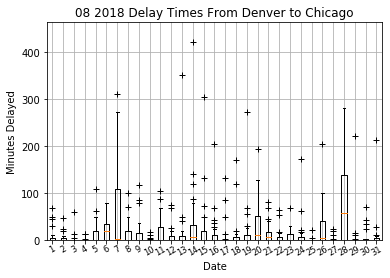

In [10]:
plotMonth("with2.txt", '08')

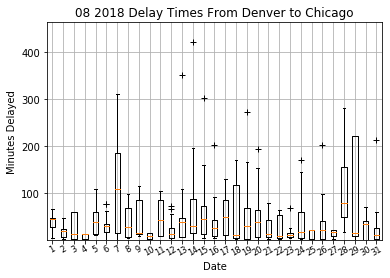

In [11]:
plotMonth("without2.txt", '08')